In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.creation import linestrings
from shapely.geometry import LineString
import networkx as nx
import osmnx as ox
from pyproj import Geod

## Wrangle Data

In [ ]:
df = pd.read_csv("data/fiber_coverage_data_2019.csv", header=0)
df = df[df["Unnamed: 5"] != "DISTANCE (M)"]

In [ ]:
df.head()

Rename Columns

In [ ]:
df.info()

In [ ]:
df = df.iloc[2:].reset_index(drop=True)
df = df.rename(
    columns={
        "AREA/ \nNEIGHBOURHOOD": "Area",
        "ROAD/STREET NAME": "road_street_name",
        "Unnamed: 5": "distance(m)",
        "Unnamed: 6": "road_ownership",
        "GPS Coordinates of road": "start_north",
        "Unnamed: 8": "start_east",
        "Unnamed: 9": "end_north",
        "Unnamed: 10": "end_east",
    }
)

In [ ]:
df

Convert some column-data-types to numeric

In [ ]:
cols_to_convert = ["distance(m)", "start_east", "end_east", "start_north", "end_north"]
# some columns are weird
for col in cols_to_convert:
    df[col] = df[col].astype(str).str.replace(",", "").str.strip()
df[cols_to_convert] = df[cols_to_convert].astype(float)
df.info()

Create a `geometry` column  hat has LineString for each row of pairs of coordinates

In [ ]:
df["geometry"] = df.apply(
    lambda row: LineString(
        [(row.start_east, row.start_north), (row.end_east, row.end_north)]
    ), axis=1
)
# df["geometry"] = [
#     LineString([(x1, y1), (x2, y2)])
#     for x1, y1, x2, y2 in zip(
#         df["start_east"], df["start_north"], df["end_east"], df["end_north"]
#     )
# ]

## Convert df to gdf

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

For the purpose of processing, convert the crs to 32361

In [ ]:
gdf = gdf.to_crs(crs="EPSG:32631")

Plot lines

In [ ]:
import  matplotlib.pyplot as plt

ax = gdf.plot(figsize=(10, 8), color="blue", linewidth=1)

# Add a basemap (optional)
ctx.add_basemap(ax, crs=gdf.crs)

plt.title("LineStrings with Basemap")
plt.show()

The lines have some discrepancies so, we'll correct them

In [ ]:
gdf

## Download Road Network and Correct Erroneous Lines

Download Lagos Roads

In [ ]:
G = ox.graph_from_place("Lagos, Nigeria", network_type="all")

|

In [ ]:
geod = Geod(ellps="WGS84")

Function to compute and fix the erroneous routes

In [ ]:
def get_routes(row, g):
    try:
        startLatLon = (row["start_north"], row["start_east"])   # starting coordinates
        endLatLon = (row["end_north"], row["end_east"])         # ending coordinates

        # check for NaN coordinates
        if pd.isna(startLatLon[0]) or pd.isna(startLatLon[1]) or pd.isna(endLatLon[0]) or pd.isna(endLatLon[1]):
            return None

        # Find nearest nodes (OSMnx expects lon,lat order)
        orig_node = ox.distance.nearest_nodes(g, X=startLatLon[1], Y=startLatLon[0])    # beginning of the line
        dest_node = ox.distance.nearest_nodes(g, X=endLatLon[1], Y=endLatLon[0])        # end of the line

        # Compute geodesic distance between snapped nodes (in meters)
        orig_coords = (g.nodes[orig_node]["y"], g.nodes[orig_node]["x"])
        dest_coords = (g.nodes[dest_node]["y"], g.nodes[dest_node]["x"])
        distance_m = geod.inv(orig_coords[1], orig_coords[0],
                              dest_coords[1], dest_coords[0])[2]

        # Only skip if they are *exactly* the same node (distance = 0)
        if distance_m == 0.0000:
            return None

        # Shortest path along the street network
        route = nx.shortest_path(g, orig_node, dest_node, weight="length")

        # making sure there are at least 2 nodes in the path
        if len(route) < 2:
            return None

        # Convert path nodes to LineString
        return LineString([(g.nodes[n]['x'], g.nodes[n]['y']) for n in route])

    except (nx.NetworkXNoPath, nx.NodeNotFound):
        # No path exists between these points
        return None

    except Exception as e:
        print(f"Routing error for row {row.name}: {e}")
        return None

Call function

In [ ]:
df["geometry"] = df.apply(lambda row: get_routes(row, G), axis=1)
successful_routes = df["geometry"].notna().sum()
print(f"Successfully routed: {successful_routes}/{len(df)}")

Convert to GeoDataframe

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [ ]:
gdf

Plot The Map

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, color="blue", linewidth=2, label="Coverage lines")
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.legend()
plt.title("Fiber Coverage over OSM Basemap", fontsize=14)
plt.show();

In [ ]:
sb = pd.read_csv(
    "https://kf.kobotoolbox.org/api/v2/assets/arwqHZFArn6CQxLEbjyVxK/export-settings/esfFLRMDYLh247njKLaL3rt/data.csv",
    sep=None,
    engine="python",
)
sb.tail(15)

## Run Script

In [1]:
from linestrings_plotter import wrangle_data, convert_to_gdf_and_plot, load_graph, correct_erroneous_line, correct_lines_in_dataframe, plot_corrected_lines

Removing a bad row
Removing more bad rows and renaming some columns
Graph download complete!
Converting coordinate reference system to UTM


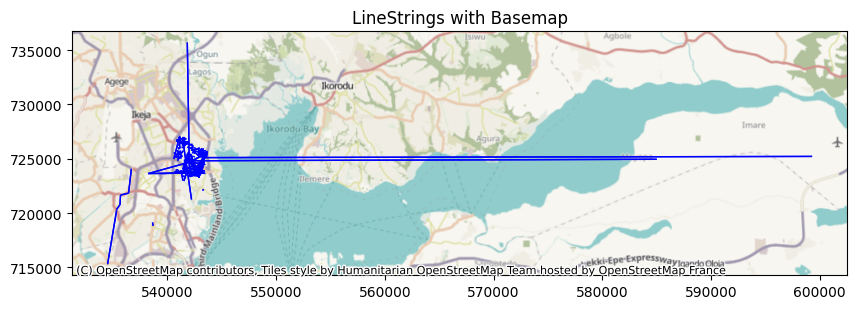

There are a few problems with the  lines, they have to be corrected
Correcting erroneous lines...
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computing shortest path...
Converting to LineStrings
Extracting Coordinates...
Computi

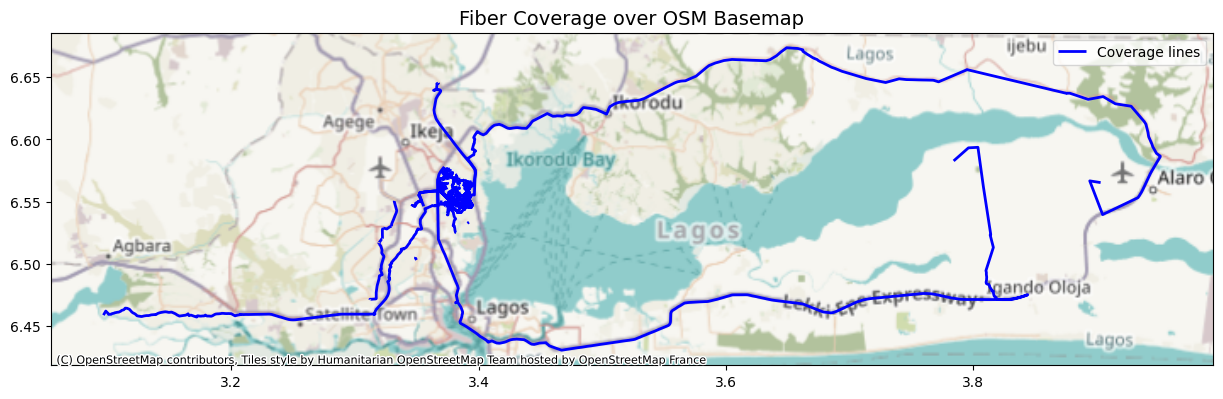

In [15]:
df = wrangle_data(data="data/fiber_coverage_data_2019.csv")
G = load_graph()
convert_to_gdf_and_plot(df)
df_fixed = correct_lines_in_dataframe(df, G)
plot_corrected_lines(data=df_fixed)

In [ ]:
# correct_erroneous_line()

In [8]:
import os
import geopandas as gpd
import leafmap.foliumap as leafmap
api_key = os.getenv("maptiler_api_key")

In [14]:
gdf = gpd.GeoDataFrame(df_fixed, geometry="geometry", crs="EPSG:4326")
m = leafmap.Map(center=[3.3984, 6.4509], zoom=3, style="streets")
style = {
    "color": "red",  # line/border color
    "weight": 2,  # line width
    "fillColor": "#3388ff",  # fill color (for polygons)
    "fillOpacity": 0.8,
}
# Add GDF with tooltip
tooltip_fields = [col for col in ["road_street_name", "LOCAL GOVERNMENT", "distance(m)"] if col in gdf.columns]
m.add_gdf(
    gdf, layer_type="fill", layer_name="Roads", style=style, tooltip_fields=tooltip_fields, info_mode="on_hover"
)
m.zoom_to_gdf(gdf)
m

In [11]:
df_fixed

,S/N,LOCAL GOVERNMENT,Area,LOCATION DESCRIPTION,road_street_name,distance(m),road_ownership,start_north,start_east,end_north,end_east,geometry
0,1.0,GBAGADA,GBAGADA EXPRESS,ATUNRASE ESTATE,ADEOLA RAJI,286.00,LASG Road,6.549160,3.387830,6.552390,3.384720,"LINESTRING (3.3877532 6.5490727, 3.3875456 6.5..."
1,2.0,GBAGADA,GBAGADA EXPRESS,ATUNRASE ESTATE,JOHNSON OGUNTUYO,508.00,LASG Road,6.552300,3.384720,6.550450,3.382940,"LINESTRING (3.3847389 6.5523475, 3.3868353 6.5..."
2,3.0,GBAGADA,GBAGADA EXPRESS,ATUNRASE ESTATE,BOLA AROWOLO,346.00,LASG Road,6.550450,3.382940,6.551300,3.380500,"LINESTRING (3.3826054 6.5499552, 3.3828038 6.5..."
3,4.0,GBAGADA,GBAGADA EXPRESS,ATUNRASE ESTATE,ALHAJI MURITALA,106.00,LASG Road,6.551000,3.383470,6.551700,3.382870,"LINESTRING (3.3834027 6.5509895, 3.3828145 6.5..."
4,5.0,GBAGADA,GBAGADA EXPRESS,ATUNRASE ESTATE,ALHAJI OWOLEGBON,265.00,LASG Road,6.551750,3.384180,6.551700,3.385910,"LINESTRING (3.3841791 6.5517936, 3.3847389 6.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...
252,NaN,OSHODI ISOLO,AIRPORT ROAD,7 AND 8,OSOLO WAY,2.37,LASG Road,6.550581,3.331811,6.530294,3.329471,"LINESTRING (3.3318063 6.5505711, 3.3317418 6.5..."
253,NaN,OSHODI ISOLO,ISOLO ROAD,ISOLO,OSOLO WAY JUNCTION TO IREAKARI JUNCTION,816.00,LASG Road,6.530294,3.329471,6.528805,3.322882,"LINESTRING (3.3295191 6.5301819, 3.3283515 6.5..."
254,NaN,OSHODI ISOLO,IRE AKARI,IRE AKARI,IRE AKARI ESTATE ROAD,953.00,LASG Road,6.528623,3.322778,6.520348,3.322301,"LINESTRING (3.3228088 6.5287722, 3.3222384 6.5..."
255,NaN,OSHODI ISOLO,IBEH STREET,IBEH STREET,IBEH STREET,592.00,LASG Road,6.520239,3.321958,6.516665,3.319453,"LINESTRING (3.3218809 6.5202534, 3.3217724 6.5..."
